# **WACO**: **W**ebb g**A**laxy **CO**unter

A simple notebook for JWST data analysis and visualization.

*Galaxy Hunters Project Submission for NASA Space Apps 2022, Hamilton*

**CSA Challenge Selected:** Exploring the distant universe with James Webb Space Telescope (Moonwalker/advanced).


**Submission Date:** October 2nd, 2022

**Galaxy Hunters Team Members:** Yusuf Ahmed, Dhvani Doshi, Ashley Ferreira, Daniel Reimer.

**Contact:** If you run into issues with this notebook or want to discuss our work, you can reach us at ashleydc.fereira@gmail.com.

This jupyter notebook is intended to help users learn:
0. How to download a JWST image using an API.
1. How to open and view an image from at least one of the sensors.
2. How to create and view a sky map that shows the region that the image covers.
3. How to Indicate when the image was acquired.
4. How to apply a custom filter to enhance the image.
5. How to count the number of galaxies visible in the image using computer vision techniques.

The last two sections of the notebook also include:
6. A bonus childrens book on JWST to inspire our future astronomers.
7. Next steps for the project.

# Installs 
Uncomment if you are missing any of the following packages.

**If you run into errors after installing these packages, especially relating to matplotlib, restart your kernel.**


In [ ]:
#! pip install ligo.skymap

In [ ]:
#! pip install photutils

In [ ]:
#! pip install pyfits

In [ ]:
#! pip install 'astropy < 4.1'

# Imports

The code below in collapsed form, img_scale.py, defines the functions needed for scaling (applying custom filters) in Section 4.

In [ ]:
#@title img_scale source code
#
# Written by Min-Su Shin
# Astrophysics, Department of Physics, University of Oxford (2012 - )
# Department of Astronomy, University of Michigan (2009 - 2012)
# Department of Astrophysical Sciences, Princeton University (2005 - 2009)
#
# You can freely use the code.
#

import numpy
import math

def sky_median_sig_clip(input_arr, sig_fract, percent_fract, max_iter=100, low_cut=True, high_cut=True):
	"""Estimating a sky value for a given number of iterations

	@type input_arr: numpy array
	@param input_arr: image data array
	@type sig_fract: float
	@param sig_fract: fraction of sigma clipping
	@type percent_fract: float
	@param percent_fract: convergence fraction
	@type max_iter: integer
	@param max_iter: max. of iterations
	@type low_cut: boolean
	@param low_cut: cut out only low values
	@type high_cut: boolean
	@param high_cut: cut out only high values
	@rtype: tuple
	@return: (sky value, number of iterations)

	"""
	work_arr = numpy.ravel(input_arr)
	old_sky = numpy.median(work_arr)
	sig = work_arr.std()
	upper_limit = old_sky + sig_fract * sig
	lower_limit = old_sky - sig_fract * sig
	if low_cut and high_cut:
		indices = numpy.where((work_arr < upper_limit) & (work_arr > lower_limit))
	else:
		if low_cut:
			indices = numpy.where((work_arr > lower_limit))
		else:
			indices = numpy.where((work_arr < upper_limit))
	work_arr = work_arr[indices]
	new_sky = numpy.median(work_arr)
	iteration = 0
	while ((math.fabs(old_sky - new_sky)/new_sky) > percent_fract) and (iteration < max_iter) :
		iteration += 1
		old_sky = new_sky
		sig = work_arr.std()
		upper_limit = old_sky + sig_fract * sig
		lower_limit = old_sky - sig_fract * sig
		if low_cut and high_cut:
			indices = numpy.where((work_arr < upper_limit) & (work_arr > lower_limit))
		else:
			if low_cut:
				indices = numpy.where((work_arr > lower_limit))
			else:
				indices = numpy.where((work_arr < upper_limit))
		work_arr = work_arr[indices]
		new_sky = numpy.median(work_arr)
	return (new_sky, iteration)



def sky_mean_sig_clip(input_arr, sig_fract, percent_fract, max_iter=100, low_cut=True, high_cut=True):
	"""Estimating a sky value for a given number of iterations

	@type input_arr: numpy array
	@param input_arr: image data array
	@type sig_fract: float
	@param sig_fract: fraction of sigma clipping
	@type percent_fract: float
	@param percent_fract: convergence fraction
	@type max_iter: integer
	@param max_iter: max. of iterations
	@type low_cut: boolean
	@param low_cut: cut out only low values
	@type high_cut: boolean
	@param high_cut: cut out only high values
	@rtype: tuple
	@return: (sky value, number of iterations)

	"""
	work_arr = numpy.ravel(input_arr)
	old_sky = numpy.mean(work_arr)
	sig = work_arr.std()
	upper_limit = old_sky + sig_fract * sig
	lower_limit = old_sky - sig_fract * sig
	if low_cut and high_cut:
		indices = numpy.where((work_arr < upper_limit) & (work_arr > lower_limit))
	else:
		if low_cut:
			indices = numpy.where((work_arr > lower_limit))
		else:
			indices = numpy.where((work_arr < upper_limit))
	work_arr = work_arr[indices]
	new_sky = numpy.mean(work_arr)
	iteration = 0
	while ((math.fabs(old_sky - new_sky)/new_sky) > percent_fract) and (iteration < max_iter) :
		iteration += 1
		old_sky = new_sky
		sig = work_arr.std()
		upper_limit = old_sky + sig_fract * sig
		lower_limit = old_sky - sig_fract * sig
		if low_cut and high_cut:
			indices = numpy.where((work_arr < upper_limit) & (work_arr > lower_limit))
		else:
			if low_cut:
				indices = numpy.where((work_arr > lower_limit))
			else:
				indices = numpy.where((work_arr < upper_limit))
		work_arr = work_arr[indices]
		new_sky = numpy.mean(work_arr)
	return (new_sky, iteration)



def range_from_zscale(input_arr, contrast = 1.0, sig_fract = 3.0, percent_fract = 0.01, max_iter=100, low_cut=True, high_cut=True):
	"""Estimating ranges with the zscale algorithm

	@type input_arr: numpy array
	@param input_arr: image data array as sample pixels to derive z-ranges
	@type contrast: float
	@param contrast: zscale contrast which should be larger than 0.
	@type sig_fract: float
	@param sig_fract: fraction of sigma clipping
	@type percent_fract: float
	@param percent_fract: convergence fraction
	@type max_iter: integer
	@param max_iter: max. of iterations
	@type low_cut: boolean
	@param low_cut: cut out only low values
	@type high_cut: boolean
	@param high_cut: cut out only high values
	@rtype: tuple
	@return: (min. value, max. value, number of iterations)

	"""
	work_arr = numpy.ravel(input_arr)
	work_arr = numpy.sort(work_arr) # sorting is done.
	max_ind = len(work_arr) - 1
	midpoint_ind = int(len(work_arr)*0.5)
	I_midpoint = work_arr[midpoint_ind]
	print(".. midpoint index ", midpoint_ind, " I_midpoint ", I_midpoint)
	# initial estimation of the slope
	x = numpy.array(range(0, len(work_arr))) - midpoint_ind
	y = numpy.array(work_arr)
	temp = numpy.vstack([x, numpy.ones(len(x))]).T
	slope, intercept = numpy.linalg.lstsq(temp, y)[0]
	old_slope = slope
	print("... slope & intercept ", old_slope, " ", intercept)
	# initial clipping
	sig = y.std()
	upper_limit = I_midpoint + sig_fract * sig
	lower_limit = I_midpoint - sig_fract * sig
	if low_cut and high_cut:
		indices = numpy.where((work_arr < upper_limit) & (work_arr > lower_limit))
	else:
		if low_cut:
			indices = numpy.where((work_arr > lower_limit))
		else:
			indices = numpy.where((work_arr < upper_limit))
	# new estimation of the slope
	x = numpy.array(indices[0]) - midpoint_ind
	y = numpy.array(work_arr[indices])
	temp = numpy.vstack([x, numpy.ones(len(x))]).T
	slope, intercept = numpy.linalg.lstsq(temp, y)[0]
	new_slope = slope
	print("... slope & intercept ", new_slope, " ", intercept)
	iteration = 1
	# to run the iteration, we need more than 50% of the original input array
	while (((math.fabs(old_slope - new_slope)/new_slope) > percent_fract) and (iteration < max_iter)) and (len(y) >= midpoint_ind) :
		iteration += 1
		old_slope = new_slope
		# clipping
		sig = y.std()
		upper_limit = I_midpoint + sig_fract * sig
		lower_limit = I_midpoint - sig_fract * sig
		if low_cut and high_cut:
			indices = numpy.where((work_arr < upper_limit) & (work_arr > lower_limit))
		else:
			if low_cut:
				indices = numpy.where((work_arr > lower_limit))
			else:
				indices = numpy.where((work_arr < upper_limit))
		# new estimation of the slope
		x = numpy.array(indices[0]) - midpoint_ind
		y = work_arr[indices]
		temp = numpy.vstack([x, numpy.ones(len(x))]).T
		slope, intercept = numpy.linalg.lstsq(temp, y)[0]
		new_slope = slope
		print("... slope & intercept ", new_slope, " ", intercept)

	z1 = I_midpoint + (new_slope / contrast) * (0 - midpoint_ind)
	z2 = I_midpoint + (new_slope / contrast) * (max_ind - midpoint_ind)

	return (z1, z2, iteration)



def range_from_percentile(input_arr, low_cut=0.25, high_cut=0.25):
	"""Estimating ranges with given percentiles

	@type input_arr: numpy array
	@param input_arr: image data array as sample pixels to derive ranges
	@type low_cut: float
	@param low_cut: cut of low-value pixels
	@type high_cut: float
	@param high_cut: cut of high-value pixels
	@rtype: tuple
	@return: (min. value, max. value)

	"""
	work_arr = numpy.ravel(input_arr)
	work_arr = numpy.sort(work_arr) # sorting is done.
	size_arr = len(work_arr)
	low_size = int(size_arr * low_cut)
	high_size = int(size_arr * high_cut)
	
	z1 = work_arr[low_size]
	z2 = work_arr[size_arr - 1 - high_size]

	return (z1, z2)



def histeq(inputArray, scale_min=None, scale_max=None, num_bins=512):
	"""Performs histogram equalisation of the input numpy array.
    
	@type inputArray: numpy array
	@param inputArray: image data array
	@type scale_min: float
	@param scale_min: minimum data value
	@type scale_max: float
	@param scale_max: maximum data value
	@type num_bins: int
	@param num_bins: number of bins in which to perform the operation (e.g. 512)
	@rtype: numpy array
	@return: image data array
    
	"""		
    
	imageData=numpy.array(inputArray, copy=True)
	if scale_min == None:
		scale_min = imageData.min()
	if scale_max == None:
		scale_max = imageData.max()
	imageData.clip(min=scale_min, max=scale_max)
	imageData = (imageData -scale_min) / (scale_max - scale_min) # now between 0 and 1.
	indices = numpy.where(imageData < 0)
	imageData[indices] = 0.0
    
	# histogram equalisation: we want an equal number of pixels in each intensity range
	image_histogram, histogram_bins = numpy.histogram(imageData.flatten(), bins=num_bins, range=(0.0, 1.0), density=True)
	histogram_cdf = image_histogram.cumsum()
	histogram_cdf = histogram_cdf / histogram_cdf[-1] # normalization

	# mapping the image values to the histogram bins
	imageData_temp = numpy.interp(imageData.flatten(), histogram_bins[:-1], histogram_cdf)
	imageData = imageData_temp.reshape(imageData.shape)
       
	return imageData



def linear(inputArray, scale_min=None, scale_max=None):
	"""Performs linear scaling of the input numpy array.

	@type inputArray: numpy array
	@param inputArray: image data array
	@type scale_min: float
	@param scale_min: minimum data value
	@type scale_max: float
	@param scale_max: maximum data value
	@rtype: numpy array
	@return: image data array
	
	"""		
	print("img_scale : linear")
	imageData=numpy.array(inputArray, copy=True)
	
	if scale_min == None:
		scale_min = imageData.min()
	if scale_max == None:
		scale_max = imageData.max()

	imageData.clip(min=scale_min, max=scale_max)
	imageData = (imageData -scale_min) / (scale_max - scale_min)
	indices = numpy.where(imageData < 0)
	imageData[indices] = 0.0
	
	return imageData


def sqrt(inputArray, scale_min=None, scale_max=None):
	"""Performs sqrt scaling of the input numpy array.

	@type inputArray: numpy array
	@param inputArray: image data array
	@type scale_min: float
	@param scale_min: minimum data value
	@type scale_max: float
	@param scale_max: maximum data value
	@rtype: numpy array
	@return: image data array
	
	"""		
    
	print("img_scale : sqrt")
	imageData=numpy.array(inputArray, copy=True)
	
	if scale_min == None:
		scale_min = imageData.min()
	if scale_max == None:
		scale_max = imageData.max()

	imageData.clip(min=scale_min, max=scale_max)
	imageData = imageData - scale_min
	indices = numpy.where(imageData < 0)
	imageData[indices] = 0.0
	imageData = numpy.sqrt(imageData)
	imageData = imageData / math.sqrt(scale_max - scale_min)
	
	return imageData


def log(inputArray, scale_min=None, scale_max=None):
	"""Performs log10 scaling of the input numpy array.

	@type inputArray: numpy array
	@param inputArray: image data array
	@type scale_min: float
	@param scale_min: minimum data value
	@type scale_max: float
	@param scale_max: maximum data value
	@rtype: numpy array
	@return: image data array
	
	"""		
    
	print("img_scale : log")
	imageData=numpy.array(inputArray, copy=True)
	
	if scale_min == None:
		scale_min = imageData.min()
	if scale_max == None:
		scale_max = imageData.max()
	factor = math.log10(scale_max - scale_min)
	indices0 = numpy.where(imageData < scale_min)
	indices1 = numpy.where((imageData >= scale_min) & (imageData <= scale_max))
	indices2 = numpy.where(imageData > scale_max)
	imageData[indices0] = 0.0
	imageData[indices2] = 1.0
	try :
		imageData[indices1] = numpy.log10(imageData[indices1])/factor
	except :
		print("Error on math.log10 for ", (imageData[i][j] - scale_min))

	return imageData


def power(inputArray, power_index=3.0, scale_min=None, scale_max=None):
	"""Performs power scaling of the input numpy array.

	@type inputArray: numpy array
	@param inputArray: image data array
	@type power_index: float
	@param power_index: power index
	@type scale_min: float
	@param scale_min: minimum data value
	@type scale_max: float
	@param scale_max: maximum data value
	@rtype: numpy array
	@return: image data array
	
	"""		
    
	print("img_scale : power")
	imageData=numpy.array(inputArray, copy=True)
	
	if scale_min == None:
		scale_min = imageData.min()
	if scale_max == None:
		scale_max = imageData.max()
	factor = 1.0 / math.pow((scale_max - scale_min), power_index)
	indices0 = numpy.where(imageData < scale_min)
	indices1 = numpy.where((imageData >= scale_min) & (imageData <= scale_max))
	indices2 = numpy.where(imageData > scale_max)
	imageData[indices0] = 0.0
	imageData[indices2] = 1.0
	imageData[indices1] = numpy.power((imageData[indices1] - scale_min), power_index)*factor

	return imageData


def asinh(inputArray, scale_min=None, scale_max=None, non_linear=2.0):
	"""Performs asinh scaling of the input numpy array.

	@type inputArray: numpy array
	@param inputArray: image data array
	@type scale_min: float
	@param scale_min: minimum data value
	@type scale_max: float
	@param scale_max: maximum data value
	@type non_linear: float
	@param non_linear: non-linearity factor
	@rtype: numpy array
	@return: image data array
	
	"""		
    
	print("img_scale : asinh")
	imageData=numpy.array(inputArray, copy=True)
	
	if scale_min == None:
		scale_min = imageData.min()
	if scale_max == None:
		scale_max = imageData.max()
	factor = numpy.arcsinh((scale_max - scale_min)/non_linear)
	indices0 = numpy.where(imageData < scale_min)
	indices1 = numpy.where((imageData >= scale_min) & (imageData <= scale_max))
	indices2 = numpy.where(imageData > scale_max)
	imageData[indices0] = 0.0
	imageData[indices2] = 1.0
	imageData[indices1] = numpy.arcsinh((imageData[indices1] - scale_min)/non_linear)/factor

	return imageData


def logistic(inputArray, scale_min=None, scale_max=None, center=0.5, slope=1.0):
	"""Performs logistic scaling of the input numpy array.

	@type inputArray: numpy array
	@param inputArray: image data array
	@type scale_min: float
	@param scale_min: minimum data value
	@type scale_max: float
	@param scale_max: maximum data value
	@type center: float
	@param center: central value
	@type slope: float
	@param slope: slope
	@rtype: numpy array
	@return: image data array
	
	"""		
    
	print("img_scale : logistic")
	imageData=numpy.array(inputArray, copy=True)
	
	if scale_min == None:
		scale_min = imageData.min()
	if scale_max == None:
		scale_max = imageData.max()
	factor2 = 1.0/(1.0+1.0/math.exp((scale_max - center)/slope))
	factor2 = factor2 + 1.0/(1.0+1.0/math.exp((scale_min - center)/slope))
	factor2 = 1.0 / factor2
	factor1 = -1.0 * factor2 / (1.0+1.0/math.exp((scale_min - center)/slope))
	indices0 = numpy.where(imageData < scale_min)
	indices1 = numpy.where((imageData >= scale_min) & (imageData <= scale_max))
	indices2 = numpy.where(imageData > scale_max)
	imageData[indices0] = 0.0
	imageData[indices2] = 1.0
	imageData[indices1] = factor1 + factor2 / (1.0 + 1.0/numpy.exp((imageData[indices1] - center)/slope))

	return imageData

In [ ]:
import sys
import os
import time
import re
import json
import numpy as np

import pyfits
import pylab

import ligo.skymap.plot
from astropy.coordinates import SkyCoord
from imageio import imread

import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style

from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.table import QTable
import astropy.units as u
from astropy.visualization import make_lupton_rgb, SqrtStretch, ImageNormalize, simple_norm
from astropy.visualization import interval, ZScaleInterval
import astropy.wcs as wcs
from astropy.coordinates import SkyCoord

import requests
from urllib.parse import quote as urlencode

from astropy.table import Table

import pprint
pp = pprint.PrettyPrinter(indent=4)

import photutils
print('photutils', photutils.__version__)

from photutils import Background2D, MedianBackground, detect_sources, deblend_sources, SourceCatalog
from photutils.utils import calc_total_error

/usr/local/lib/python3.7/dist-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


photutils 1.3.0


\\
# 0. Download JWST Image

First, input the object of interest, stated as the "Target Name" on the Mikulski Archive for Space Telescopes (MAST).

In [ ]:
object_of_interest = 'SMACS J0723.3-7327'
show_output = True

Download JWST object of interest from MAST.

In [ ]:
def mast_query(request):
    """Perform a MAST query.
    
        Parameters
        ----------
        request (dictionary): The MAST request json object
        
        Returns head,content where head is the response HTTP headers, and content is the returned data"""
    
    # Base API url
    request_url='https://mast.stsci.edu/api/v0/invoke'    
    
    # Grab Python Version 
    version = ".".join(map(str, sys.version_info[:3]))

    # Create Http Header Variables
    headers = {"Content-type": "application/x-www-form-urlencoded",
               "Accept": "text/plain",
               "User-agent":"python-requests/"+version}

    # Encoding the request as a json string
    req_string = json.dumps(request)
    req_string = urlencode(req_string)
    
    # Perform the HTTP request
    resp = requests.post(request_url, data="request="+req_string, headers=headers)
    
    # Pull out the headers and response content
    head = resp.headers
    content = resp.content.decode('utf-8')

    return head, content


resolver_request = {'service':'Mast.Name.Lookup',
                     'params':{'input':object_of_interest,
                               'format':'json'},
                     }

headers, resolved_object_string = mast_query(resolver_request)

resolved_object = json.loads(resolved_object_string)

if show_output:
  pp.pprint(resolved_object)

obj_ra = resolved_object['resolvedCoordinate'][0]['ra']
obj_dec = resolved_object['resolvedCoordinate'][0]['decl']

mast_request = {'service':'Mast.Caom.Cone',
                'params':{'ra':obj_ra,
                          'dec':obj_dec,
                          'radius':0.2},
                'format':'json',
                'pagesize':2000,
                'page':1,
                'removenullcolumns':True,
                'removecache':True}

headers, mast_data_str = mast_query(mast_request)

mast_data = json.loads(mast_data_str)

if show_output:
  print(mast_data.keys())
  print("Query status:",mast_data['status'])

mast_data_table = Table()

for col,atype in [(x['name'],x['type']) for x in mast_data['fields']]:
    if atype=="string":
        atype="str"
    if atype=="boolean":
        atype="bool"
    mast_data_table[col] = np.array([x.get(col,None) for x in mast_data['data']],dtype=atype)

if show_output:    
  print(mast_data_table)

arr = np.array(mast_data_table['obs_collection'])
np.unique(arr)
interesting_observation = mast_data_table[mast_data_table["obs_collection"] == "JWST"]

# Picking the first JWST observation
interesting_observation = mast_data_table[mast_data_table["obs_collection"] == "JWST"][0]
if show_output: 
  print("Observation:",
      [interesting_observation[x] for x in ['dataproduct_type', 'obs_collection', 'instrument_name']])

obsid = interesting_observation['obsid']

product_request = {'service':'Mast.Caom.Products',
                  'params':{'obsid':obsid},
                  'format':'json',
                  'pagesize':100,
                  'page':1}   

headers, obs_products_string = mast_query(product_request)

obs_products = json.loads(obs_products_string)

if show_output:
  print("Number of data products:", len(obs_products["data"]))
  print("Product information column names:")
  pp.pprint(obs_products['fields'])

  pp.pprint([x.get('productType',"") for x in obs_products["data"]])

sci_prod_arr = [x for x in obs_products['data'] if x.get("productType", None) == 'SCIENCE']
science_products = Table()

for col, atype in [(x['name'], x['type']) for x in obs_products['fields']]:
    if atype=="string":
        atype="str"
    if atype=="boolean":
        atype="bool"
    if atype == "int":
        atype = "float" # array may contain nan values, and they do not exist in numpy integer arrays
    science_products[col] = np.array([x.get(col,None) for x in sci_prod_arr],dtype=atype)

if show_output:
  print("Number of science products:",len(science_products))
  print(science_products)

download_url = 'https://mast.stsci.edu/api/v0.1/Download/file?'

for row in science_products[:2]:     

    # make file path
    out_path = os.path.join("mastFiles", row['obs_collection'], row['obs_id'])
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    out_path = os.path.join(out_path, os.path.basename(row['productFilename']))
        
    # Download the data
    payload = {"uri":row['dataURI']}
    resp = requests.get(download_url, params=payload)
    
    # save to file
    with open(out_path,'wb') as FLE:
        FLE.write(resp.content)
        
    # check for file 
    if not os.path.isfile(out_path):
        print("ERROR: " + out_path + " failed to download.")
    else:
        print("COMPLETE: ", out_path)

{   'resolvedCoordinate': [   {   'cached': False,
                                  'canonicalName': 'SMACS J0723.3-7327',
                                  'decl': -73.457,
                                  'objectType': 'GClstr',
                                  'ra': 110.8054,
                                  'resolver': 'NED',
                                  'resolverTime': 472,
                                  'searchRadius': -1.0,
                                  'searchString': 'smacs j0723.3-7327'}],
    'status': ''}
dict_keys(['status', 'msg', 'data', 'fields', 'paging'])
Query status: COMPLETE
intentType obs_collection provenance_name ...  obsid   distance _selected_
---------- -------------- --------------- ... -------- -------- ----------
   science           TESS            SPOC ... 60865631      0.0      False
   science           TESS            SPOC ... 60902971      0.0      False
   science           TESS            SPOC ... 60942213      0.0      False
   sci

\\
# 1. Display object of interest
It's okay if you only see a black plot below, you often need to apply additional scaling to these images in order to visually see the features.

Filename: mastFiles/JWST/jw02736-o001_t001_nircam_clear-f090w/jw02736-o001_t001_nircam_clear-f090w_i2d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     371   ()      
  1  SCI           1 ImageHDU        75   (10272, 4758)   float32   
  2  ERR           1 ImageHDU        10   (10272, 4758)   float32   
  3  CON           1 ImageHDU         9   (10272, 4758)   int32   
  4  WHT           1 ImageHDU         9   (10272, 4758)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (10272, 4758)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (10272, 4758)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (10272, 4758)   float32   
  8  HDRTAB        1 BinTableHDU    816   72R x 403C   [23A, 5A, 3A, 45A, 7A, 13A, 5A, 5A, 7A, 10A, 4A, L, D, D, D, D, 32A, 48A, 33A, 21A, 3A, 3A, D, D, 10A, 12A, 23A, 23A, 26A, 11A, 5A, 3A, 3A, 2A, 1A, 2A, 1A, L, 14A, 24A, 2A, 26A, 20A, 27A, 10A, K, L, L, L, L, 18A, 18A, 5A, D, D, D, D, D, D, D,

Text(0, 0.5, 'pixels')

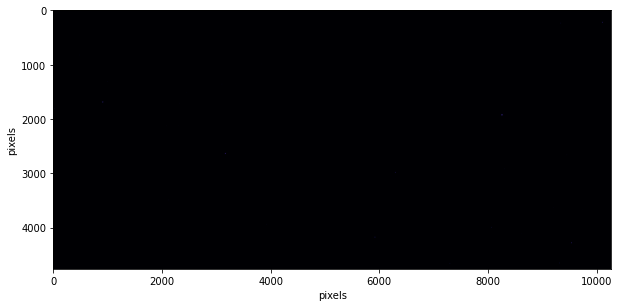

In [ ]:
image_file = get_pkg_data_filename(out_path)

if show_output:
  fits.info(image_file)

image_data = fits.getdata(image_file, ext=1)

if show_output:
  print(image_data.shape)

plt.figure(figsize=(10,5))
plt.imshow(image_data, cmap='magma')
#plt.colorbar()
plt.xlabel('pixels')
plt.ylabel('pixels')

\\
# 2. Create Sky Map

In order to create a map of the object of interest on the sky we need to read in its position from the header, this is given in terms of Right Ascension (RA) and Declination. The code below creates a celestial sphere to visualize where the target is located.

In [ ]:
# read in RA and Dec from .fits file header
img_header = fits.getheader(image_file)
ra = img_header['PROP_RA']
dec = img_header['PROP_DEC']

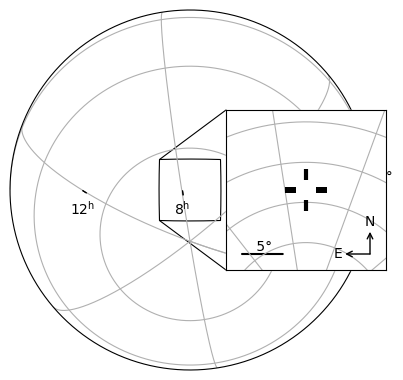

In [ ]:
# define the center of the observation
center = SkyCoord(ra, dec, unit='deg') 

# intialize a figure
plt.style.use('default')
fig = plt.figure(figsize=(4, 4), dpi=100)

# plot the celestial sphere
ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro globe',
    center=center)

# plot the inset (zoomed in) map
ax_inset = plt.axes(
    [0.59, 0.3, 0.4, 0.4],
    projection='astro zoom',
    center=center,
    radius=10*u.deg)

# add grid lines to both the 
# inset map and sphere
ax.grid()
ax_inset.grid()

# don't label the axis of the inset map
for key in ['ra', 'dec']:
    ax_inset.coords[key].set_ticklabel_visible(False)
    ax_inset.coords[key].set_ticks_visible(False)

# additional formatting
ax.mark_inset_axes(ax_inset)
ax.connect_inset_axes(ax_inset, 'upper left')
ax.connect_inset_axes(ax_inset, 'lower left')
ax_inset.scalebar((0.1, 0.1), 5 * u.deg).label()
ax_inset.compass(0.9, 0.1, 0.2)

# plot the location of target on inset map
ax_inset.plot(
    center.ra.deg, center.dec.deg,
    transform=ax_inset.get_transform('world'),
    marker=ligo.skymap.plot.reticle(),
    markersize=30,
    markeredgewidth=3, color='black')
plt.show()

You can also view the location of the observation using a flattened skymap. Here we also show that it is possible to read in any background image. The background image shown below is Planck’s first all-sky map, showing the Milky Way across the middle and the CMB behind.

(-0.5, 1199.5, 599.5, -0.5)

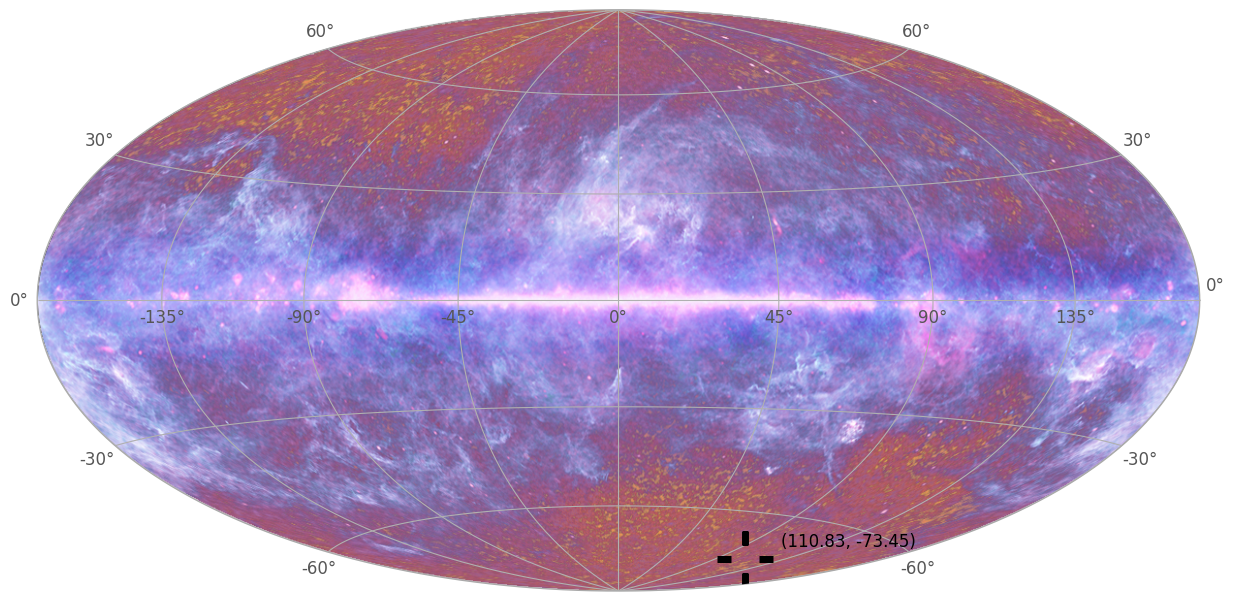

In [ ]:
# read in image available online
url1 = 'https://plancksatellite.org.uk/wp-content/uploads/sites/2/2019/09/PLANCK_FSM_03_cropped_0.png'
f1 = imread(url1)

# initialize figure
plt.style.use(astropy_mpl_style)
fig, ax_img = plt.subplots(figsize = (15,10))

# plot the image from online (80% transparent)
ax_img.imshow(f1, alpha=0.8)

# plot the flat sky map and degree line labels
ax_proj = plt.axes(projection='geo aitoff')

# plot the location of the target
ax_proj.plot(
    center.ra.deg, center.dec.deg,
    transform=ax_proj.get_transform('world'),
    marker=ligo.skymap.plot.reticle(),
    markersize=40,
    markeredgewidth=5, color='black')

# plot text on image next to target showing its 
# coordinates rounded to 2 decimal places
pos = '(' + str(round(ra,2)) + ', ' + str(round(dec,2)) + ')'
ax_proj.text(ra+2, dec+5, pos, fontsize=12, transform=ax_proj.get_transform('world'))

# additional formatting
ax_proj.patch.set_alpha(0.01)
ax_img.set_xticks([])
ax_img.set_yticks([])
ax_img.axis("off")

\
\
This can also be done for other sky map backgrounds such as a star atlas, allowing you to reference the constellations visible in the night sky of your region to that of the target image coordinates.

(-0.5, 1023.5, 767.5, -0.5)

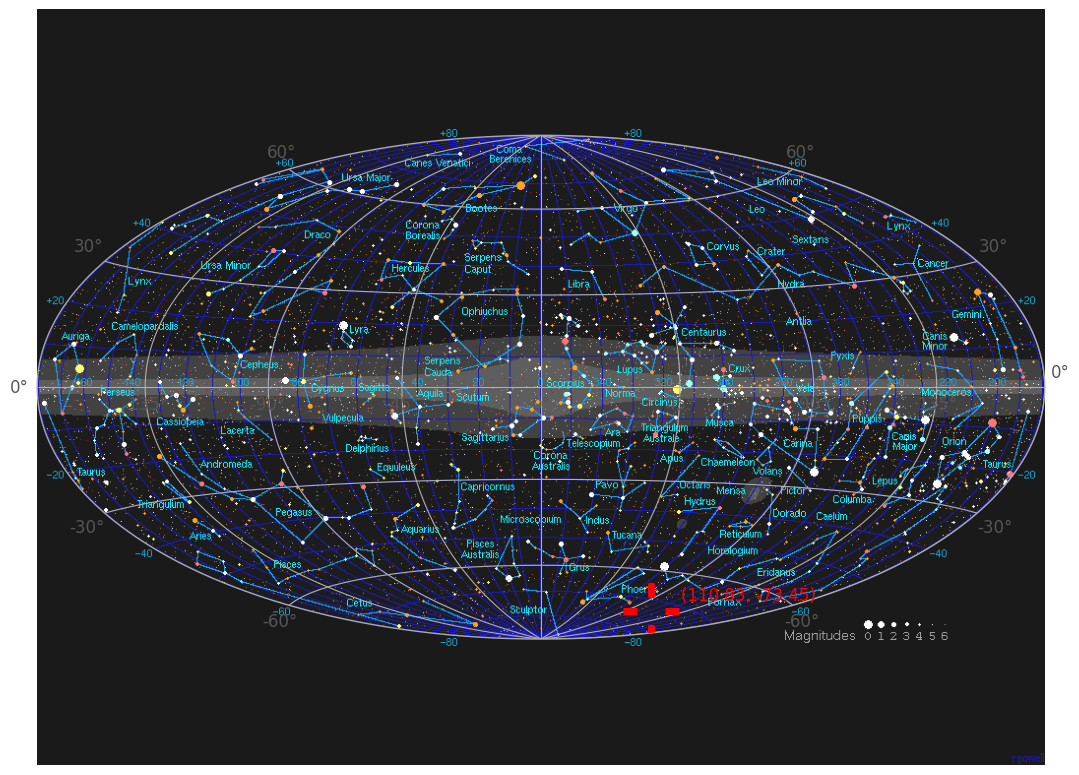

In [ ]:
url2 = 'http://www.atlasoftheuniverse.com/galchart.gif'
f2 = imread(url2)

plt.style.use(astropy_mpl_style)
fig, ax_img = plt.subplots(figsize = (13,10))

ax_proj = plt.axes(projection='geo aitoff')
ax_proj.plot(
    center.ra.deg, center.dec.deg,
    transform=ax_proj.get_transform('world'),
    marker=ligo.skymap.plot.reticle(),
    markersize=40,
    markeredgewidth=5, color='red')
ax_proj.patch.set_alpha(0.01)

pos = '(' + str(round(ra,2)) + ', ' + str(round(dec,2)) + ')'
ax_proj.text(ra+2, dec+5, pos, color='red', fontsize=12, transform=ax_proj.get_transform('world'))

ax_img.imshow(f2, alpha=0.9)
ax_img.set_xticks([])
ax_img.set_yticks([])
ax_img.axis("off")

\\
# 3. When was the image acquired

In [ ]:
print('Date of Observation:', img_header['DATE-OBS'])
print('Time of Observation:', img_header['TIME-OBS'])

Date of Observation: 2022-06-07
Time of Observation: 00:34:53.548000


\\
# 4. Custom Filter
Below it is shown how to apply any filter that is defined by a function called 'transform_data()'. The example function here shows the recomended custom filter, called zscale.

In [ ]:
def transform_data(data):
  zscale = ZScaleInterval()
  (z1, z2) = zscale.get_limits(image_data)
  normer = interval.ManualInterval(z1, z2)
  return normer(image_data)

In [ ]:
custom_filter = transform_data

Text(0, 0.5, 'pixels')

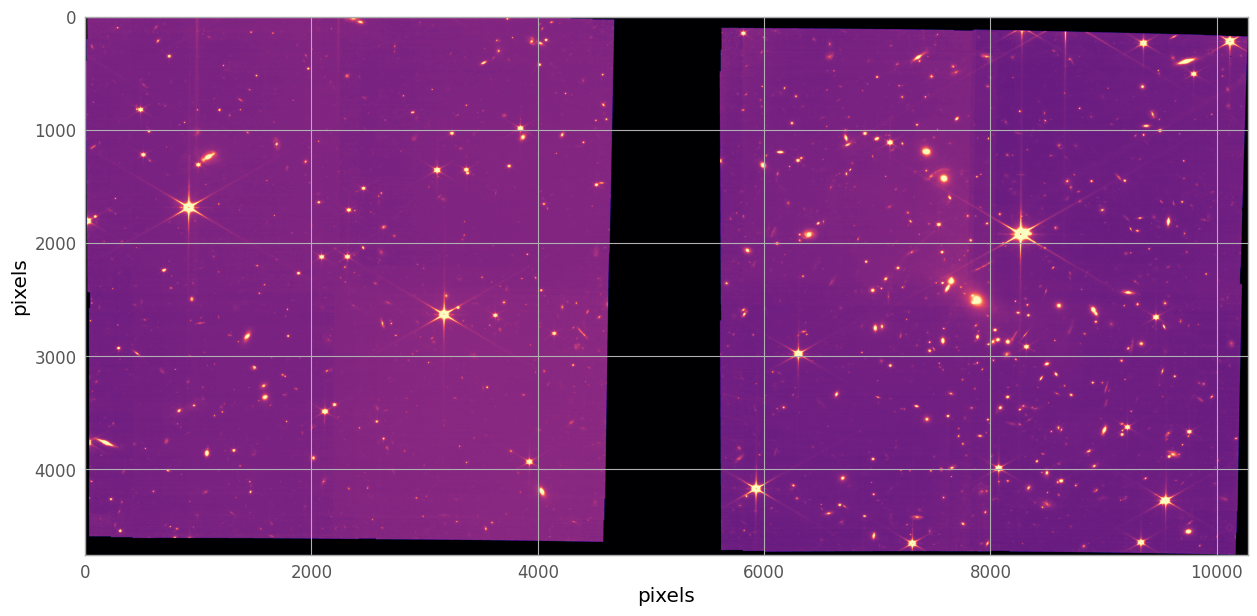

In [ ]:
plt.figure(figsize=(15,10))
plt.imshow(custom_filter(image_data), cmap='magma')
#plt.colorbar()
plt.xlabel('pixels')
plt.ylabel('pixels')

Below are several examples on how to apply several other custom filters. These are methods of scaling the data defined by functions stated in the "img_scale.py" file at the start of this notebook. These include sclaing methods: linear, square root, power, log, arcsinh, histogram, and logistic. The number parameters in some may be adjusted to the liking of the user or based on the data file.

sky =  0.19375962 ( 0 )
... min. and max. value :  -0.2707766 673.62573
img_scale : linear


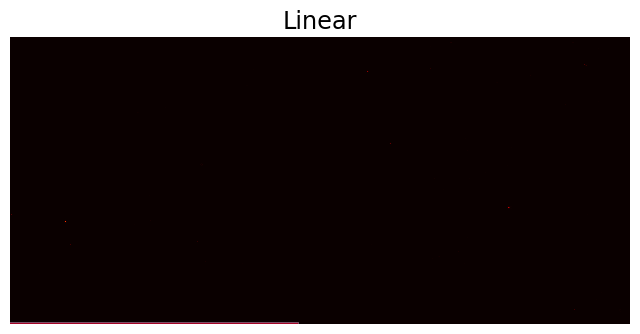

img_scale : sqrt


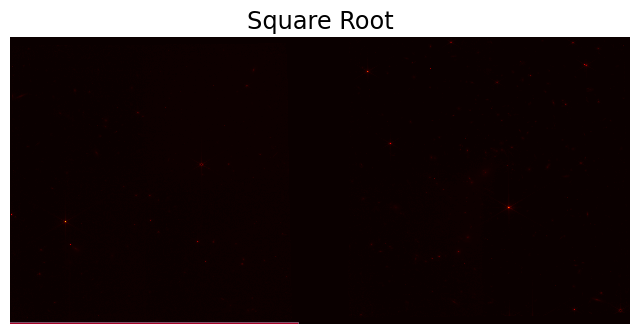

img_scale : power


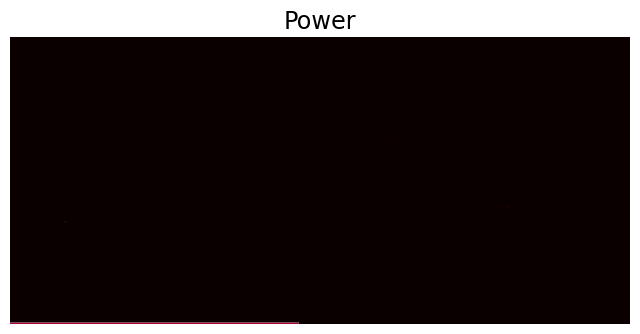

img_scale : log


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:357: RuntimeWarning: divide by zero encountered in log10


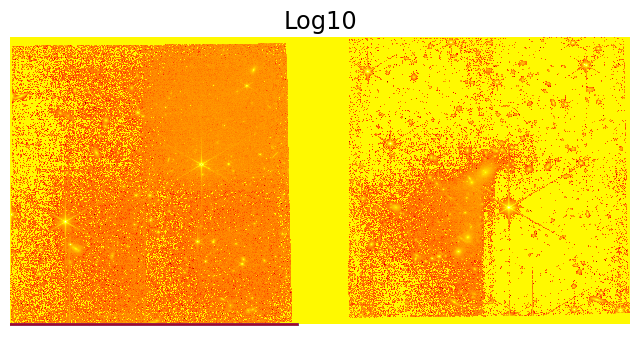

img_scale : asinh


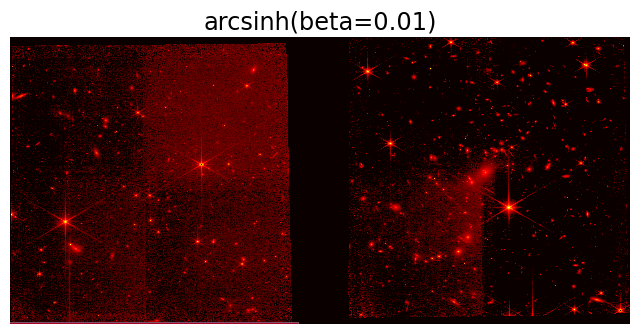

img_scale : asinh


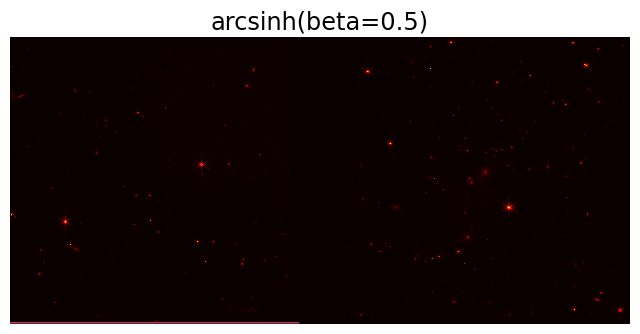

img_scale : asinh


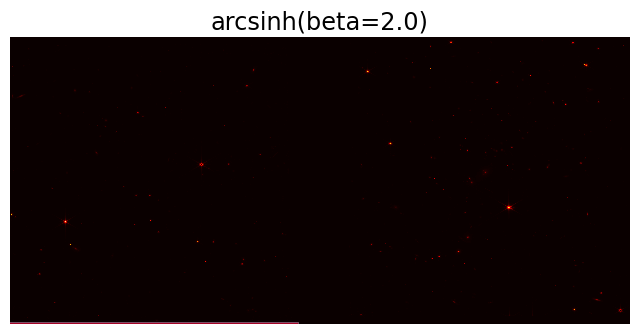

<Figure size 800x600 with 0 Axes>

In [ ]:
sig_fract, percent_fract = 5.0, 0.01

sky, num_iter = sky_median_sig_clip(image_data, sig_fract, percent_fract, max_iter=100)
#sky, num_iter = img_scale.sky_mean_sig_clip(img_data_raw, sig_fract, percent_fract, max_iter=10)
print("sky = ", sky, '(', num_iter, ')')
img_data = image_data - sky
min_val = 0.0
print("... min. and max. value : ", numpy.min(img_data), numpy.max(img_data))

# Linear

new_img = linear(img_data, scale_min = min_val)
pylab.imshow(new_img, interpolation='nearest', origin='lower', cmap=pylab.cm.hot)
pylab.axis('off')
#pylab.savefig('linear.png')
plt.plot(new_img)
plt.title("Linear")
plt.show()
pylab.clf()


# Square Root

new_img = sqrt(img_data, scale_min = min_val)
pylab.imshow(new_img, interpolation='nearest', origin='lower', cmap=pylab.cm.hot)
pylab.axis('off')
#pylab.savefig('sqrt.png')
plt.plot(new_img)
plt.title("Square Root")
plt.show()
pylab.clf()


# Power

new_img = power(img_data, power_index=2.0, scale_min = min_val)
pylab.imshow(new_img, interpolation='nearest', origin='lower', cmap=pylab.cm.hot)
pylab.axis('off')
#pylab.savefig('power.png')
plt.plot(new_img)
plt.title("Power")
plt.show()
pylab.clf()


# Log10

new_img = log(img_data, scale_min = min_val)
pylab.imshow(new_img, interpolation='nearest', origin='lower', cmap=pylab.cm.hot)
pylab.axis('off')
#pylab.savefig('log.png')
plt.plot(new_img)
plt.title("Log10")
plt.show()
pylab.clf()


# arcsinh(beta=0.01)

new_img = asinh(img_data, scale_min = min_val, non_linear=0.01)
pylab.imshow(new_img, interpolation='nearest', origin='lower', cmap=pylab.cm.hot)
pylab.axis('off')
#pylab.savefig('asinh_beta_0.01.png')
plt.plot(new_img)
plt.title("arcsinh(beta=0.01)")
plt.show()
pylab.clf()


# arcsinh(beta=0.5)

new_img = asinh(img_data, scale_min = min_val, non_linear=0.5)
pylab.imshow(new_img, interpolation='nearest', origin='lower', cmap=pylab.cm.hot)
pylab.axis('off')
#pylab.savefig('asinh_beta_0.5.png')
plt.plot(new_img)
plt.title("arcsinh(beta=0.5)")
plt.show()
pylab.clf()


# arcsinh(beta=2.0)

new_img = asinh(img_data, scale_min = min_val, non_linear=2.0)
pylab.imshow(new_img, interpolation='nearest', origin='lower', cmap=pylab.cm.hot)
pylab.axis('off')
#pylab.savefig('asinh_beta_2.0.png')
plt.plot(new_img)
plt.title("arcsinh(beta=2.0)")
plt.show()
pylab.clf()

Uncomment the code block below at your own risk, running it may take a very long time and potentially cause errors depending on the image.

In [ ]:
#@title Additional scaling methods: Histogram Equalisation & Logistic Distribtion (disabled by default)
# Histogram Equalisation

#new_img = histeq(img_data_raw, num_bins=256)
#pylab.imshow(new_img, interpolation='nearest', origin='lower', cmap=pylab.cm.hot)
#pylab.axis('off')
#pylab.savefig('histeq.png')
#plt.plot(new_img)
#plt.title("Histogram Equalisation")
#plt.show()
#pylab.clf()

# Logistic Distribtion

#new_img = logistic(img_data_raw, center = 0.03, slope = 0.3)
#pylab.imshow(new_img, interpolation='nearest', origin='lower', cmap=pylab.cm.hot)
#pylab.axis('off')
#pylab.savefig('logistic.png')
#plt.title("Logistic Distribtion")
#plt.plot(new_img)
#plt.show()
#pylab.clf()

\\
# 5. Count Number of Galaxies
The code below was largely taken and adapted from one of the [James Webb Space Telescope Data Analysis Tool Notebooks](https://github.com/spacetelescope/jdat_notebooks/blob/main/notebooks/NIRCam_photometry/NIRCam_multiband_photometry.ipynb) provided by the Space Telescope Science Institute.

In the linked notebook the authors require a threshold of 5 connected pixels 2-sigma above background to detect a source. However, since we are dealing with an image that has not been PSF-fitted this threshold is increased to 10 connected pixels and 2-sigma above the background in hopes to detect less diffraction patterns as additional sources and falsely increase the number of unique sources.

In [ ]:
# Measure background and set detection threshold
bkg_estimator = MedianBackground()
bkg = Background2D(image_data, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
threshold = bkg.background + (3. * bkg.background_rms)

# Before detection, smooth image with Gaussian FWHM = 3 pixels
sigma = 3.0 * gaussian_fwhm_to_sigma  
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()

# Detect and deblend
segm_detect = detect_sources(image_data, threshold, npixels=10, kernel=kernel)
segm_deblend = deblend_sources(image_data, segm_detect, npixels=5, kernel=kernel, nlevels=32, contrast=0.001)

# Save segmentation map of detected objects
segm_hdu = fits.PrimaryHDU(segm_deblend.data.astype(np.uint32))
segm_hdu.writeto('segm.fits', overwrite=True)

Text(0.5, 1.0, 'Detections')

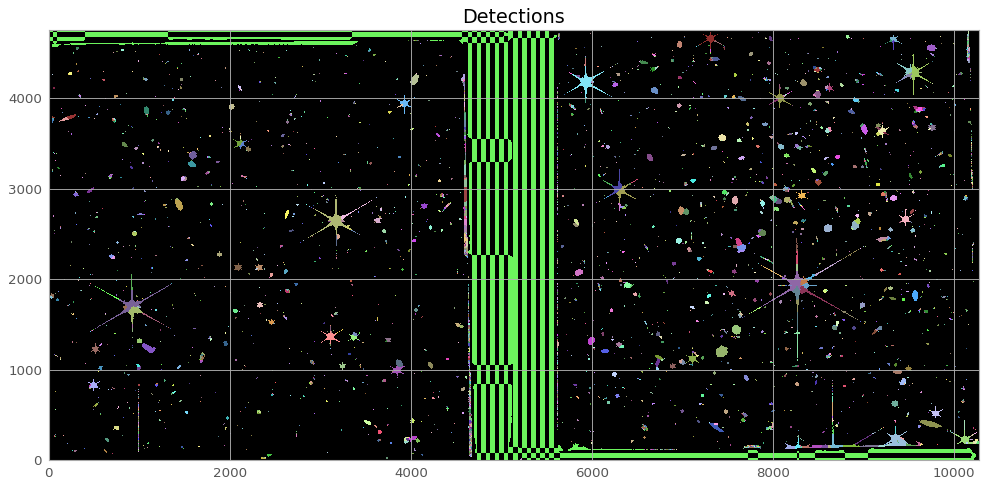

In [ ]:
# Segmentation map
cmap = segm_deblend.make_cmap(seed=12345)

plt.figure(figsize=(15, 10), dpi=80)

plt.imshow(segm_deblend, origin='lower', cmap=cmap, interpolation='nearest')
plt.title('Detections')

The following lines two lines require a high-RAM runtime environment

In [ ]:
cat = SourceCatalog(image_data-bkg.background, segm_deblend, background=bkg.background)

In [ ]:
cat.to_table()

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,,,,,,pix2,pix,pix,deg,,,,,,,,
int64,float64,float64,object,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,4284.926316359852,2622.125973949273,None,0,10238,0,4757,2954335.0,2784.942865528785,863.533555031405,-44.90677114951913,0.9507129890891108,-0.14029746323229902,591.3442392754677,0.0,25281.925307013957,nan,nan,nan
2,5214.1125357091105,6.134497957419582,None,5206,5224,0,19,279.0,5.130921196832438,3.6390935758527503,45.92025270084817,0.70495945505104,1.2257178533682765e-09,5.571439730933688e-08,0.0,8.288283866916226e-06,nan,nan,nan
3,2409.9184456407766,9.519600532070122,None,2406,2414,6,13,44.0,2.361338518726469,1.4984934413164734,39.55646143291062,0.7728449265921512,0.12235552321462714,0.2648963865722612,0.0,7.840491860240722,nan,12.209272869260621,nan
4,3730.400794395139,22.333311664760977,None,3720,3741,14,32,311.0,2.6064363979590754,2.4460367026544008,-5.3121161651245465,0.3453875213517777,0.10392551469133857,31.941444350122307,0.0,445.9625218298572,nan,419.24424145832063,nan
5,2431.948893436329,53.13902178902444,None,2404,2460,38,69,1328.0,11.821094607051052,6.032002265859107,12.666228135903141,0.8600116337134659,0.058054402832741436,1.3783507304811549,0.0,326.22549333488587,nan,496.81253520594856,nan
6,4120.123053479898,54.204217088009436,None,4103,4134,47,62,334.0,6.455444252097435,3.064429544871681,-13.135614375077244,0.88014514404861,0.06468859750192046,0.5269358473568407,0.0,67.14883704972527,nan,103.20584939209157,nan
7,2959.148675669086,56.20980085509529,None,2956,2963,50,61,60.0,2.293343953230874,1.455831331632774,89.70401902385773,0.7726705479190978,0.03896892194146645,0.6082848260238016,0.0,9.504185833461026,nan,14.267083703939868,nan
8,1763.7975815652467,57.494190971024224,None,1762,1765,56,59,11.0,0.8527787408269099,0.7486393877318475,-50.28364263520684,0.47887640907375956,0.0424001206753046,0.26047212129184594,0.0,1.2348747126317843,nan,1.977196351651436,nan


In [ ]:
print('estimation for number galaxies in image:', len(cat))

estimation for number galaxies in image: 6305


It is clear from the detection image that the source detection algorithm struggles with the area between each of the fields of view, in future both sections should be cropped so they can be analyzed individually. This method of estimation also struggles with how to handle the diffraction lines. Ideally these would be removed by PSF-fitting and then the algorithm would perform better. Due to this false detection of sources on diffraction lines struggles at diffraction lines, as well as the fact some of these sources are stars and some of the glaxies are lensed and therefore appear more than once, this number is an overestimation.


There is no current ground truth value to compare our estimate to. However, Hubble imaged the same target in 2017 and almost 3,000 galaxies were said to be in that image. Both the JWST and Hubble field of views are very comparable, with one of the two JWST frames covering the same area as Hubble and the other one covering an adjacent and less densly populated area. Therefore, the fact that the number of detections our algorithm finds is over twice that of Hubble is an indication that JWST is very likely able to see more galaxies.


\\
# 6. [Bonus: JWST Childrens Book](https://docs.google.com/presentation/d/1NBhjQr4VUlcelc2IOWOsWD9ibopgtHQ_LBpFTsxp_es/edit?usp=sharing)


A childrens book about the James Webb Space Telescope written by GPT3 and illustrated by DALLE2.



\\
# 7. Next Steps

Machine learning methods are currently being developed to aid in galaxy detection. They use several deep learning methods to succesfully detect galaxies within images. This includes convolutional neural networks, support vector machines, and several image processsing techniques. These novel methods can be validated and compared against current methods like the galaxy count method used in this notebook. These machine learning techniques can be further improved with the influx of data that will be recieved by JWST in hopes of developing more accurate models. 

Several papers discuss the novel methods they have designed that use machine learning algorithms to detect galaxies. A couple of these papers are listed below: 

1. [Galaxy detection and identification using deep learning and data augmentation](https://www.sciencedirect.com/science/article/pii/S2213133718300325)
2. [Galaxy Detection Machine Learning Project](https://www.epfl.ch/labs/mlo/wp-content/uploads/2021/05/crpmlcourse-paper845.pdf) 

As a continuation to this challenge, we can also develop a machine learning algorithm utilizing a convolutional neural network to detect the number of galaxies from JWST images. We can utilize the JWST image simulators such as Mirage for our training set and use data augmentation techniques to develop a more robust training set. We can then use the real JWST images as our test set.

If we had more time our group would have liked to add a section to this tutorial detailing how to combine images from different filters in order to create the truly beautiful colour images we seen in the recent months from JWST.

Additionally, once an API is released to programatically interface with DALLE2 we will be able to automatically and interactively generate story content such as what we demonstrated in section 6. Hopefully, this could inspire our future astronomers and more broadly just make JWST interactive to more than just folks looking to perform data analysis.



\\
# References
Thank you to all the space apps organizers, mentors, and judges, we truly appreciate how much time and effort you put into making this such a great experience for our team.

This project used the facilities of the Canadian Astronomy Data Centre, operated by the National Research Council of Canada with the support of the Canadian Space Agency, and the facilities of the NASA funded Mikulski Archive for Space Telescopes for obtaining data from the James Webb Space Telescope. \\
\
The services of GPT3 and DALLE2 OpenAIs were used in Section 6. \\
\
$\bullet$ [Section 0] Adapted code from MAST API Tutorial: https://mast.stsci.edu/api/v0/MastApiTutorial.html \\
$\bullet$ [Section 2] Star atlas sky map background retrieved from http://www.atlasoftheuniverse.com/galchart.html \\
$\bullet$ [Section 2] Planck's CMB sky map background retrieved from https://plancksatellite.org.uk/ \\
$\bullet$ [Section 4] The img_scale.py file used for image scaling is written by Min-Su Shin (Astrophysics, Department of Physics, University of Oxford (2012 - )) and has free access. Retrieved from https://www.sciserver.org/wp-content/uploads/2016/04/img_scale.py_.txt \\
$\bullet$ [Section 5] Adapted galaxy counting code, courtesy of Space Telescope Science Institute: https://github.com/spacetelescope/jdat_notebooks/blob/main/notebooks/NIRCam_photometry/NIRCam_multiband_photometry.ipynb \\
$\bullet$ ligo.skymap package: https://lscsoft.docs.ligo.org/ligo.skymap/ \\
$\bullet$ photoutils package: https://photutils.readthedocs.io/en/stable/ \\
$\bullet$ pyfits package: https://pyfits.readthedocs.io/en/latest/ \\
$\bullet$ astropy package: https://www.astropy.org/ \\